### 1️⃣ Importaciones y configuración

In [ ]:
import sys
import os

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=RuntimeWarning)

BASE_DIR = os.path.abspath(os.path.join(os.path.dirname("__file__"), "..", ".."))
OUTPUT_DIR = os.path.join(BASE_DIR, "output")
TRAIN_CSV = os.path.join(OUTPUT_DIR, "train_processed.csv")
VAL_CSV   = os.path.join(OUTPUT_DIR, "val_processed.csv")
TEST_CSV  = os.path.join(OUTPUT_DIR, "test_processed.csv")

sys.path.insert(0, BASE_DIR)

from src.part_2.main import run_training
from src.part_2.train_housing_bp import TrainBP

### 2️⃣ Funciones de evaluación de métricas

In [ ]:
def mape(y_true, y_pred):
    """Mean Absolute Percentage Error"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape_val = mape(y_true, y_pred)
    return {
        "MSE": float(mse),
        "MAE": float(mae),
        "MAPE": float(mape_val)
    }


### 4️⃣ Cargar datos usando las variables del notebook


In [ ]:
import pandas as pd

hyperparameter_sets = [
    {"activation": "relu",    "layers": [277, 32, 16, 1],    "epochs": 150, "lr": 0.001,  "momentum": 0.9},
    {"activation": "relu",    "layers": [277, 64, 32, 1],    "epochs": 200, "lr": 0.0005, "momentum": 0.9},
    {"activation": "tanh",    "layers": [277, 20, 10, 1],    "epochs": 200, "lr": 0.05,   "momentum": 0.9},
    {"activation": "tanh",    "layers": [277, 40, 20, 1],    "epochs": 250, "lr": 0.02,   "momentum": 0.8},
    {"activation": "sigmoid", "layers": [277, 20, 10, 1],    "epochs": 70,  "lr": 0.001,  "momentum": 0.9},
    {"activation": "sigmoid", "layers": [277, 50, 25, 1],    "epochs": 120, "lr": 0.005,  "momentum": 0.7},
    {"activation": "linear",  "layers": [277, 1],            "epochs": 200, "lr": 1e-6,   "momentum": 0},
    {"activation": "relu",    "layers": [277, 128, 64, 1],   "epochs": 250, "lr": 0.0003, "momentum": 0.9},
    {"activation": "tanh",    "layers": [277, 64, 32, 1],    "epochs": 150, "lr": 0.01,   "momentum": 0.7},
    {"activation": "sigmoid", "layers": [277, 10, 5, 1],     "epochs": 80,  "lr": 0.002,  "momentum": 0.8},
]

results = []

for i, params in enumerate(hyperparameter_sets, start=1):
    print(f"\n=== Running configuration {i} / {len(hyperparameter_sets)} ===")
    print(params)

    nn, pid_test, y_test, preds, trainer_obj = run_training(
        activation=params["activation"],
        layers=params["layers"],
        epochs=params["epochs"],
        lr=params["lr"],
        momentum=params["momentum"],
        CSV_TRAIN=TRAIN_CSV,
        CSV_VAL=VAL_CSV,
        CSV_TEST=TEST_CSV,
        verbose=False
    )

    metrics = evaluate_model(y_test, preds)

    results.append({
    "layers": params["layers"],
    "epochs": params["epochs"],
    "lr": params["lr"],
    "momentum": params["momentum"],
    "activation": params["activation"],
    "MAPE": metrics["MAPE"],
    "MAE":  metrics["MAE"],
    "MSE":  metrics["MSE"],
    "trainer": trainer_obj,
    "y_test": y_test,       
    "preds": preds          
    })

df_results = pd.DataFrame(results)

In [ ]:
import matplotlib.pyplot as plt

df_results["nlayers"] = df_results["layers"].apply(len)

columns_to_show = [
    "nlayers",
    "layers",      
    "epochs",    
    "lr",          
    "momentum",     
    "activation",   
    "MAPE",
    "MAE",
    "MSE"
]

df_display = df_results[columns_to_show].copy()
for col in ["MAPE", "MAE", "MSE"]:
    df_display[col] = df_display[col].round(2)

df_display.columns = [
    "Number of Layers",
    "Layer Structure",
    "Num Epochs",
    "Learning Rate",
    "Momentum",
    "Activation Function",
    "MAPE",
    "MAE",
    "MSE"
]

fig, ax = plt.subplots(figsize=(20,6))
ax.axis('off')

table = ax.table(
    cellText=df_display.values,
    colLabels=df_display.columns,
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.5, 1.5)

plt.tight_layout()
plt.show()


### 2️⃣ Scatter Plots of predicted values

In [ ]:

df_sorted = df_results.sort_values("MAPE").reset_index(drop=True)

representative_indices = [0, len(df_sorted)//2, len(df_sorted)-1]  # Best, middle, worst

plt.figure(figsize=(18, 5))

for i, idx in enumerate(representative_indices, start=1):
    row = df_sorted.iloc[idx]
    
    y_test_values = row["y_test"] 
    preds = row["preds"]
    
    plt.subplot(1, 3, i)
    plt.scatter(y_test_values, preds, alpha=0.6, edgecolor='k')
    
    min_val = min(min(y_test_values), min(preds))
    max_val = max(max(y_test_values), max(preds))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    
    plt.title(
        f"Activation: {row['activation']}\n"
        f"Layers: {row['layers']}\n"
        f"Epochs: {row['epochs']}, LR: {row['lr']}, Momentum: {row['momentum']}\n"
        f"MAPE: {row['MAPE']:.2f}%, MAE: {row['MAE']:.2f}, MSE: {row['MSE']:.2e}"
    )
    
    plt.xlabel("Real Value")
    plt.ylabel("Predicted Value")
    plt.grid(True)

plt.tight_layout()
plt.show()




### 2️⃣ Training and validation Error Evolution

Training Neural Network...
Training Neural Network...
Training Neural Network...


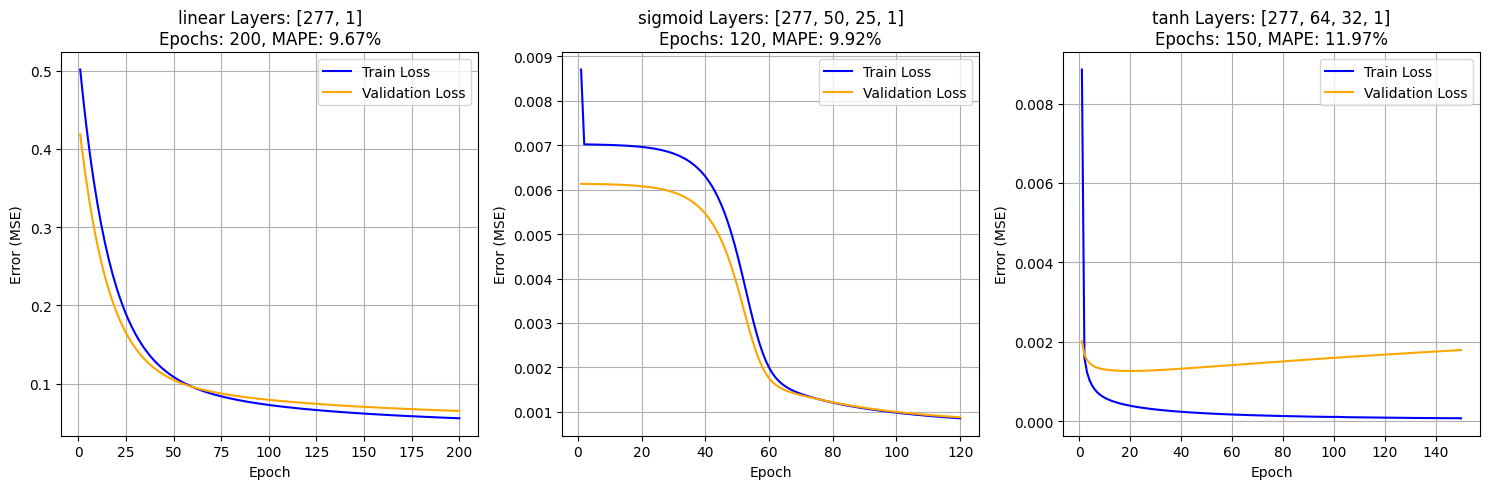

In [ ]:
import matplotlib.pyplot as plt

df_results = pd.DataFrame(results)
df_best = df_results.sort_values("MAPE").head(3).reset_index(drop=True)

for i, row in df_best.iterrows():
    nn, pid_test, y_test, preds, trainer_obj = run_training(
        activation=row["activation"],
        layers=row["layers"],
        epochs=row["epochs"],
        lr=row["lr"],
        momentum=row["momentum"],
        CSV_TRAIN=TRAIN_CSV,
        CSV_VAL=VAL_CSV,
        CSV_TEST=TEST_CSV,
        verbose=False
    )
    
    df_best.at[i, "trainer"] = trainer_obj
    df_best.at[i, "y_test"] = y_test
    df_best.at[i, "preds"] = preds

plt.figure(figsize=(15, 5))

for i, (_, row) in enumerate(df_best.iterrows(), start=1):
    trainer = row["trainer"]
    loss_df = trainer.loss_epochs()
    
    train_loss = loss_df["Train Error"].values
    val_loss = loss_df["Val Error"].values
    
    plt.subplot(1, 3, i)
    plt.plot(range(1, len(train_loss)+1), train_loss, label="Train Loss", color="blue")
    plt.plot(range(1, len(val_loss)+1), val_loss, label="Validation Loss", color="orange")
    plt.title(
        f"{row['activation']} Layers: {row['layers']}\n"
        f"Epochs: {row['epochs']}, MAPE: {row['MAPE']:.2f}%"
    )
    plt.xlabel("Epoch")
    plt.ylabel("Error (MSE)")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

